<style>
@font-face {font-family: "B Nazanin"; src: url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.eot"); src: url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.eot?#iefix") format("embedded-opentype"), url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.woff2") format("woff2"), url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.woff") format("woff"), url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.ttf") format("truetype"), url("//db.onlinewebfonts.com/t/3671adca6f650c92b83f906e49656986.svg#B Nazanin") format("svg"); }
    </style>
<div dir="rtl" align="center" style ='font-family: "B Nazanin";'>
    <h1>
        تمرین اول درس پردازش زبان‌های طبیعی
    </h1>
    <h3>
        گردآورندگان:<br/>
        ساحل مس‌فروش، سروش تابش، درنا دهقانی
    </h3>
    
</div>

<br/>
<br/>


<div dir="rtl"  style ='font-family: "B Nazanin";'>
    ما در این تمرین ترک "استخراج پرسش و پاسخ" را انتخاب کردیم. در این تمرین قصد داریم از یک جمله فارسی سوالاتی با توجه به روابط علت و معلولی، نقش کلمات در جملات، ارتباط بین واژگان و ... استخراج کنیم. هر سوال به شکل یک دیکشنری پایتون نمایش داده می‌شود که key سوال و value پاسخ به سوال است. گام ابتدایی ما برای پاسخ به این ترک، جستجوی مسائل مشابه بود و از آنجایی که این مسئله هم‌چنان باز است، روش‌های متعددی مبتنی بر Deep Learning یافتیم که چون از مبحث این تمرین خارج بودند، از آنها استفاده نکردیم.
</div>

<div dir="rtl" style ='font-family: "B Nazanin";'>
    <h2> 1. تمیز کردن ورودی </h2>
    در این بخش، گام‌های ابتدایی برای مراحل آتی را برمی‌داریم. هر جمله که به عنوان ورودی ما داده می‌شود، باید تا حد مناسبی تمیز و ساختاریافته شود تا به عنوان ورودی بخش‌های بعد معتبر باشد. کارهایی مانند نرمال‌سازی و ... در این بخش انجام می‌گردد. از توابع تعریف شده در کتابخانه hazm استفاده می‌کنیم.

    دقت کنید از آن‌جایی که در مواردی مانند کتابخانه  hazm به خوبی عمل نمی‌کند، بهتر است جمله‌ی ورودی تا جای ممکن نرمالایز شده باشد و تا جای ممکن از چنین مشکلاتی دوری شود.
    
</div>

In [1]:
!pip install hazm
!pip install camel-tools
!pip install Tashaphyne
!pip install parstdex~=1.1.0

#  نصب کتاب‌خانه مورد نیاز برای اتصال به وب‌سرویس فارس‌نت
! pip install zeep

     |████████████████████████████████| 102 kB 401 kB/s eta 0:00:01
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
     |████████████████████████████████| 418 kB 487 kB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 447 kB/s eta 0:00:01
  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)
     |████████████████████████████████| 86 kB 433 kB/s eta 0:00:01
  Using cached future-0.18.2.tar.gz (829 kB)
     |████████████████████████████████| 175 kB 411 kB/s eta 0:00:01
     |████████████████████████████████| 286 kB 498 kB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 246 kB/s eta 0:00:01
     |████████████████████████████████| 764 kB 160 kB/s eta 0:00:01
  Using cached filelock-3.6.0-py3-none-any.whl (10.0 kB)
     |████████████████████████████████| 84 kB 106 kB/s eta 0:00:01
     |████████████████████████████████| 880 kB 49 kB/s eta 0:00:012
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x

In [1]:
import re
from collections import Counter
import json
import os
from itertools import chain
import collections
import hazm
import random
import numpy as np
import nltk
import pandas as pd
import codecs
import tqdm
import itertools
import functools
import operator
import matplotlib
from zeep import Client
from requests.auth import HTTPBasicAuth
from requests import Session
from zeep.transports import Transport

In [3]:
def sentence_clean(sentence: str):
    normalizer = hazm.Normalizer()
    sentence = normalizer.normalize(sentence)
    return sentence.split('. ')

sentence = 'چون بارون اومده  ، رنگین کمونه. هوا بارونیه. '
print(sentence_clean(sentence))

['چون بارون اومده، رنگین کمونه', 'هوا بارونیه', '']


<div dir="rtl" style ='font-family: "B Nazanin";'>
    <h2> 2. استخراج ساختار سوالات </h2>
    جملاتی که امکان استخراج سوالات از آنها ممکن است، دو نوعند. نوع اول دارای برخی کلمات کلیدی (مانند زیرا، چون و ...) هستند. نوع دوم جملاتی هستند که فاقد اینگونه کلماتند. مثلاً امروز هوا بارانیست: امروز هوا چگونه است؟ بارانی. در طراح این بخش از ماژول <code>cause_effect_extractions</code> ایده گرفتیم.<br>
    <h4> 2.1. استخراج سوال از جملات با کلمات کلیدی </h4>
    در این مرحله، به یافتن کلمات کلیدی در جملاتی که امکان استخراج سوالات از آنها وجود دارد پرداختیم. در یک Google Sheet لیست این کلمات، انواع نحوه به کارگیری آنها در جملات، مثال‌هایی از هر یک و هم‌چنین ساختار سوال و جواب و مثال از آنها را مشخص کردیم. 
    هم‌چنین مثال‌هایی از جملات را به عنوان داده‌ی تست یافتیم و سوال‌هایی از آنها استخراج کردیم.
    <a href="https://docs.google.com/spreadsheets/d/1qsCfRVr5RgXYW2qEVbrP3dq7-l3wNngjPAsXrHN89DQ/edit#gid=0" target="_top">فهرست کلمات کلیدی و جملات تست</a><br/>
    سپس در تابع <code>extract_cause_effect</code> از جمله‌ای که به عنوان ورودی داده می‌شود، با توجه به ساختار جمله که ورودی دیگر این تابع و از انواع پرسش و پاسخ است، رابطه‌ی علت و معلولی که ممکن است در جمله باشد، استخراج می‌گردد.<br>
    در دیکشنری <code>all_regexes</code> نوع و ساختار جملاتی که قابلیت طرح سوال از آنها وجود دارد توسط regex طراحی شده است. هم‌چنین ساختار پرسش و پاسخ آنها نیز وجود دارد.<br>
    اگر ساختار regex در جمله موجود بود، بسته به اینکه کدام بخش جمله در سوال و کدام بخش آن در جواب استفاده شود، سوال و جواب از جمله ساخته شده و در دیکشنری خروجی تابع قرار می‌گیرد.
    همچنین برای ساختار جملاتی که از تا به عنوان حرف ربط استفاده کرده اند برای بررسی اینکه آیا تا حرف ربط است یا خیر از کلاس
    CauseEffectExtraction
    کتابخانه‌ی 
    parsi.io
     کمک گرفته شد. بدین ترتیب که در صورتی که ساختار پیدا شده مربوط به حروف ربط باشد به کمک این کلاس بررسی میکنیم که آیا حروف پیدا شده حرف ربط هستند یا حرف اضافه و در صورتی که این کلاس بتواند ساختار 
     cause and effect
     تشخیص دهد به استخراج سوال می‌پردازیم. 
</div>

In [19]:
import re
from cause_effect_extractions import CauseEffectExtraction
all_regexes = {
  "چرایی": {"regex": r"""(?P<effect>.*)[،|؛|](?P<reason> زیرا| چون| به‌دلیل| بدلیل|چون\sکه | به\sدلیل\sاینکه)(?P<cause>.*)|چون(?P<cause2>.*)(،|\s،|؛)(?P<effect2>.*)""", "q_as": [{"question": "چرا {effect} ؟", "answer": "زیرا {cause}"}]}, 
  "سببی": {"regex": r"(?P<effect>.*) (?P<reason>مسبب|دلیل|مسبّب) (?P<cause>.*) [است|شد|شدند]|(?P<reason2>مسبب|دلیل) (?P<effect2>.*)[،|؛] (?P<cause2>) است.", "q_as": [{"question": "{effect} باعث چه می شود؟ ", "answer": "باعث {cause}"}, {"question": "چه باعث  {cause} می‌شود?", "answer": "{effect}"}]},
  "موجب": {"regex":r"(?P<effect>.*) موجب (?P<cause>.*) می‌شود.*|(?P<effect2>.*) موجبات (?P<cause2>.*) فراهم می‌کند","q_as": [{ "question": "چه موجب {effect} می‌شود؟", "answer": "{cause}"}, {"question": "{cause} موچب چه می‌شود؟", "answer": "موجب {effect}"}]},
  "ترین": {"regex":r"(?P<tarin>.*ترین) (?P<cause>.*)[،|؛](?P<effect>.*) است", "q_as": [{"question": "{tarin} {cause} چیست؟", "answer": "{effect}"}]},
  "خاطر": {"regex": r"""(?P<reason> بخاطر|به خاطر) (?P<cause>.*)[،|] (?P<effect>.*)|(?P<effect2>.*) (?P<reason2> بخاطر|به خاطر) (?P<cause2>.*)""","q_as": [{ "question": "چرا {effect} ؟", "answer": "به خاطر {cause}"}]},
  "منجر": {"regex": r"(?P<cause>.*)(?P<reason> منجر به)(?P<effect>.*)می شود.|(?P<reason2>مسبب|دلیل) (?P<effect2>.*)[،|؛] (?P<cause2>) است.", "q_as": [{"question": "علت {effect} چیست؟", "answer": "{cause}"}]},
   "هدف": {"regex":r"هدف (?P<effect>.*) (?P<reason>این\sاست\sکه|این\sاست) (?P<cause>.*)", "q_as": [{"question": "هدف {effect} چیست؟", "answer": "{cause}"}]},
   "تا": {"regex":r"(?P<effect>.*) (?P<reason>تا) (?P<cause>.*)", "q_as": [{ "question": "چرا {effect} ?", "answer": "{cause}"}]},
   "علت": {"regex": r"(?P<reason>علت) (?P<effect>.*)[،|؛] (?P<cause>.*) است", "q_as": [{ "question": "علت {effect} چیست؟", "answer": "{cause}"}]},
   "نتیجه": {"regex": r"(?P<effect>.*) (?P<reason>نتیجه‌ی|نتیجه\sی) (?P<cause>.*) [است|هستند]", "q_as": [{ "question": "{effect} نتیجه‌ی چیست؟", "answer": "{cause}"}]}
}

cause_effect_extractor_keys = ["تا", ]

def validate_ta_regex(text, key):
  effect_extractor = CauseEffectExtraction()
  result = effect_extractor.run(text)
  if not result[1] is None:
    return result[1] == key
  return False

def get_all_not_none_groups(x):
  group_dicts = x.groupdict()
  groups = {}
  for key, value in group_dicts.items():
    if value:
      if key == "cause2" or key == "effect2" or key == "reason2":
        groups[key[:-1]] = value
      else:
        groups[key] = value
  if (not "cause" in groups.keys()) or (not "effect" in groups.keys()):
    print("bad input")
    return None # cause and effect shouldn't be empty
  return groups

def extract_cause_effects(text: str, key: str):
  """extracting cause and effect parts from text based on key regex. creating a Q&A based on key question format and answer format
  Parameters
  ---------
  text: str
    sentence query used to extract question and answers.
  key: str
    key should be one of all_regexes.keys(). sentence format used to extract Q&A
  
  
  Returns
  -------
  result: dict
    includes question and answer sentences.
    """

  key_information = all_regexes.get(key, None)
  if not key_information:
    print("you should specify current key information in all_regexes dict")
    return
  regex = key_information.get("regex")
  first_reg = re.compile(regex)
  x = re.search(first_reg, text)
  if x is not None:
    regex_groups = get_all_not_none_groups(x)
    if regex_groups is None:
      return
  else:
    # regex didn't found the structure. 
    return None
  if key in cause_effect_extractor_keys:
    if not validate_ta_regex(text, key):
      print("regex not validated with cause effect extractor")
      return None
  results = []
  q_as = key_information.get("q_as")
  for q_a in q_as:
    q_format = q_a.get("question")
    a_format = q_a.get("answer")  
    result = {"question": q_format.format(**regex_groups), "answer": a_format.format(**regex_groups)}
    results.append(result)
  return results

<div dir="rtl" style ='font-family: "B Nazanin";'>
    در تابع <code>extract_question</code> ابتدا روی تمامی ساختارهای موجود که امکان طرح سوال از آنها وجود دارد، پیمایشی انجام می‌گیرد. در هر پیمایش، هر ساختار از <code>all_regexes</code> در جمله‌ی ورودی توسط تابع <code>extract_cause_effects</code> بررسی می‌گردد و در صورت داشتن خروجی معتبر، پرسش و پاسخ مربوطه‌ی آن نمایش داده می‌شود.
</div>

In [20]:
def extract_questions(text: str):
    """
    checking all different sentence formats on text. if one is applied ignore others and return
    Parameters
    ----------
    text: str
        input sentence(s)
    
    Returns
    ------
    result: dict
      question and answer sentences.
    """
    text = sentence_clean(text)
    for t in text:
      if len(t) > 1:
        for key, value in all_regexes.items():
            result = extract_cause_effects(t, key)
            if result:
                print(result)
                return result
    
sentence = 'بارون موجب رنگین کمون می‌‌شود'
extract_questions(sentence)

<div dir='rtl' style ='font-family: "B Nazanin";'>
    <h4>2.2. استخراج سوال از جملات بدون کلمات کلیدی</h4>
    عملکرد کلی در این بخش بدین صورت است که امکان پرسش با حذف بخشی از جمله ممکن است و به جای بخش حذف شده، ضمیر پرسشی مربوطه جایگزین آن می‌گردد و سوال تشکیل می‌شود. در نتیجه بخش حذف شده از جمله، پاسخ به آن پرسش است.<br>
    مثلاً در جمله‌ی "او کتاب را برداشت."، با حذف "او" که اشاره به فرد دارد و جایگزین کردن "چه کسی" یک سوال ساخته می‌شود. هم‌چنین با حذف "کتاب" که اشاره به شیء دارد و جایگزین کردن "چه چیزی" می‌توان سوال دیگری ساخت.<br>
    چالشی که در این بخش با آن مواجه بودیم، نحوه برخورد با گروه‌های اسمی بود که با حرف اضافه شروع می‌شدند. مثلاً در جمله‌ی "او با آرامش راه رفت." تشخیص اینکه "با" حرف ربط یا حرف اضافه است برای ما مسئله بود. در چنین شرایطی تصمیم گرفتیم به کلمه‌ی پیش از این حرف نگاه کنیم و اگر فعل بود، آن را حرف ربط و در غیر اینصورت حرف اضافه در نظر بگیریم. در این صورت کلمه‌ی پرسشی مناسب برای گروه اسمی "با آرامش"، "چگونه" است. <br>
    برای استفاده از تابع <code>POSTagger</code> از کتابخانه‌ی hazm، به دلیل مشکلاتی که در استفاده‌ی مستقیم از کتابخانه‌ی آن پیش می‌آمد، مجبور شدم از محتوای این تابع به شکلی دستی استفاده کنم در فولدر resources قرار دارد.
</div>

In [49]:
# download "resources" from here: https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip
tagger = hazm.POSTagger(model='./resources/postagger.model')

<div dir='rtl' style ='font-family: "B Nazanin";'>
  بخش‌های قابل پرسش در جمله به چهار گروه متممی، مفعولی، نهادی و قیدی تقسیم می‌شوند. در تابع <code>extract_structure</code> برای هر یک از این ساختارها، regex مربوطه نوشته شده و به کمک تابع <code>POSTagger</code> کتابخانه‌ی hazm، درخت روابط واژگانی جمله نمایش داده می‌شود.
  دقت کنید که این
  POSTagger
  نیز چالش‌های زیادی دارد که بر دقت کد تاثیر می‌گذارند. به طور مثال عدد سه می‌تواند به عنوان صفت و یا اسم در نظر گرفته بشود و گاهی جایگاه آن اشتباه تشخیص داده ‌می‌شود.
  
  با تقسیم جمله به گروه‌های اسمی مختلف و تشخیص نوع این گروه‌ها به کمک 
  FarsiNet
  می‌توان هرکدام از آن‌ها را با ضمیر پرسشی مناسب جایگزین کرد
</div>

In [52]:
questionable_poses = {
    'MOTAMEMI': {'pos_hint_word': 'Noun', 'pos_hint_expression': ['N', 'Ne', 'AJ', 'AJe']},
    'MAFOULI': {'pos_hint_word': 'Noun', 'pos_hint_expression': ['N', 'Ne']},
    'NAHADI': {'pos_hint_word': 'Noun', 'pos_hint_expression': ['N', 'Ne']},
    'GHEIDI': {'pos_hint_word': 'Adverb', 'pos_hint_expression': ['ADV']},
    'ADAD': {'pos_hint_expression': ['NUM']},
}


def extract_structures(sentence):
    neutral_words = r"N|Ne|PRO|PROe"
    grammar = r"""
      MOTAMEMI:  {<P|Pe><N|Ne>(<CONJ>?<N|Ne|AJ|AJe>)*}
      MAFOULI:   {<N|Ne><POSTP>}
      NAHADI:    {<DET>?<NW>((<CONJ><NW>)|<AJe|AJ>)*}
      GHEIDI:    {<ADV>+}
      ADAD:      {<NUM>+}
    """
    grammar = grammar.replace('NW', neutral_words)
    cp = nltk.RegexpParser(grammar)
    return cp.parse(sentence)

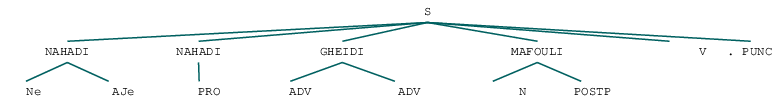

In [22]:
tree = extract_structures(tagger.tag(hazm.word_tokenize('کد زیبای ما خیلی سریع سوال‌ها را جواب‌داد.')))
tree

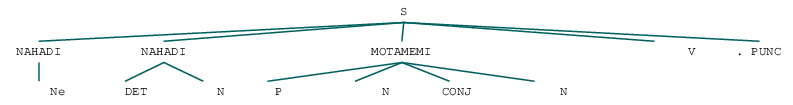

In [23]:
tree = extract_structures(tagger.tag(hazm.word_tokenize('میزان این تورم به سیاست‌ها و نگرش‌ها بستگی‌دارد.')))
tree

<div dir='rtl' style ='font-family: "B Nazanin";'>
  برای تشخیص اسنادی بودن یا نبودن یک جمله از تابع <code>is_linking_centence</code> استفاده می‌کنیم و بررسی اسنادی بودن فعل جمله توسط تابع <code>is_linking_verb</code> انجام می‌گردد.
</div>

In [8]:
LINKING_VERBS = {'است', 'بود', 'شد', 'گشت', 'گردید', 'هست'}


def is_linking_verb(verb):
    verb = set(hazm.Lemmatizer().lemmatize(verb).split('#'))
    return bool(LINKING_VERBS.intersection(verb))


def is_linking_sentence(sentence_tokens):
    words = tagger.tag(sentence_tokens)
    verb_types = map(is_linking_verb, map(lambda x: x[0], filter(lambda x: x[1] == 'V', words)))
    return functools.reduce(operator.or_, verb_types, False)

is_linking_sentence(hazm.word_tokenize('این خانه زیبا است.'))

True

<div dir="rtl" style ='font-family: "B Nazanin";'>
  برای تشخیص نوع بخش حذف شده از جمله و جایگزینی ضمیر پرسشی مناسب، از کتابخانه‌ی wordnet فارسی یا فارس‌نت استفاده کردیم. ابتدا ثبت نام کرده و مراحل لازم برای اتصال به آن را انجام دادیم.
</div>

In [9]:
# address of FarsNet's web services
wsdl_sense_service = 'http://nlp.sbu.ac.ir:8180/WebAPI/services/SenseService?WSDL'
wsdl_synset_service = 'http://nlp.sbu.ac.ir:8180/WebAPI/services/SynsetService?WSDL'


# username and token needed for authentication. You can get this token by signing up on http://farsnet.nlp.sbu.ac.ir
# users = [{"username": ""}, {"username"}]
username = 'USERNAME'
token = 'TOKEN'

# connecting client
session = Session()
session.auth = HTTPBasicAuth(username, token)
client_sense = Client(wsdl_sense_service, transport=Transport(session=session))
client_synset = Client(wsdl_synset_service, transport=Transport(session=session))

<div dir="rtl" style ='font-family: "B Nazanin";'>
  برای انتخاب ضمیر پرسشی مناسب، لازم است نوع واژه را از نظر اشاره داشتن به فرد، مکان، زمان و یا حالت بدانیم. به کمک تابع <code>getSensesByWord</code> می‌توان درباره‌ی هر واژه اطلاعاتی به دست آورد. فیلد nounCategory اطلاعاتی در مورد خاص یا غیر خاص بودن اسم  می‌دهد. مثلاً برای نام "فاطمه" این فیلد برابر با <code>Specific</code> و برای "درخت" برابر با <code>None</code> است. فیلد می‌تواند در مورد نوع نام، مانند انسان بودن اطلاعاتی به ما دهد.<br>
  به کمک تابع <code>getSynsetsByWord</code> و فیلد semanticCategory از آن نیز می‌توان در مورد نوع قیود از نظر زمانی و مکانی و غیره بودن را تشخیص داد. مثال‌هایی از این دو تابع را می‌توان مشاهده کرد:
</div>

In [10]:
request = {"searchKeyword": "درخت", "userKey": "d428e755-3b91-11eb-8a1e-080027d731c1", "searchStyle": "EXACT"}
sense = client_sense.service.getSensesByWord(**request)
print(sense)

request = {"searchKeyword": "فاطمه", "userKey": "d428e755-3b91-11eb-8a1e-080027d731c1", "searchStyle": "EXACT"}
sense = client_sense.service.getSensesByWord(**request)
print(sense)

request = {"searchKeyword": "دیروز", "userKey": "d428e755-3b91-11eb-8a1e-080027d731c1", "searchStyle": "EXACT"}
sense = client_synset.service.getSynsetsByWord(**request)
print(sense)

request = {"searchKeyword": "آنجا", "userKey": "d428e755-3b91-11eb-8a1e-080027d731c1", "searchStyle": "EXACT"}
sense = client_synset.service.getSynsetsByWord(**request)
print(sense)

[{
    'adjectiveType1': None,
    'adjectiveType2': None,
    'adverbType1': None,
    'adverbType2': None,
    'id': 30551,
    'isAbbreviation': False,
    'isCausative': False,
    'isColloquial': False,
    'isIdiomatic': False,
    'nounCategory': 'General',
    'nounNumeralType': None,
    'nounPluralType': None,
    'nounSpecifityType': None,
    'nounType': 'Simple',
    'preNounAdjectiveType': None,
    'pronoun': None,
    'seqId': '0',
    'synsetId': '12142',
    'transitiveType': None,
    'value': 'درخت',
    'verbActivePassive': None,
    'verbPastStem': None,
    'verbPresentStem': None,
    'verbTransitivity': None,
    'verbType': None,
    'word': {
        'defaultPhonetic': 'deraxt',
        'defaultValue': 'درخت',
        'id': 21951,
        'pos': 'Noun'
    }
}]
[{
    'adjectiveType1': None,
    'adjectiveType2': None,
    'adverbType1': None,
    'adverbType2': None,
    'id': 40372,
    'isAbbreviation': False,
    'isCausative': False,
    'isColloquial': 

In [54]:
# address of FarsNet's web services
wsdl_sense_service = 'http://nlp.sbu.ac.ir:8180/WebAPI/services/SenseService?WSDL'
wsdl_synset_service = 'http://nlp.sbu.ac.ir:8180/WebAPI/services/SynsetService?WSDL'

# username and token needed for authentication. You can get this token by signing up on http://farsnet.nlp.sbu.ac.ir
# users = [{"username": ""}, {"username"}]
username = 'SahelMesforoush'
token = 'd428e755-3b91-11eb-8a1e-080027d731c1'

# connecting client
session = Session()
session.auth = HTTPBasicAuth(username, token)
client_sense = Client(wsdl_sense_service, transport=Transport(session=session))
client_synset = Client(wsdl_synset_service, transport=Transport(session=session))


def get_sense(word):
    word = hazm.Lemmatizer().lemmatize(word)
    request = {"searchKeyword": word, "userKey": token, "searchStyle": "EXACT"}
    sense = client_sense.service.getSensesByWord(**request)
    return sense


def get_synset(word):
    word = hazm.Lemmatizer().lemmatize(word)
    request = {"searchKeyword": word, "userKey": token, "searchStyle": "EXACT"}
    sense = client_synset.service.getSynsetsByWord(**request)
    return sense

<div dir="rtl" style ='font-family: "B Nazanin";'>
بدین ترتیب به کمک این توابع می‌توان نوع بسیاری از واژگان یا گروه‌های اسمی را تشخیص داد و متناسب اسم خاص یا غیرخاص، انسان یا غیر انسان، حالت، ارتباط، مکان ، زمان و ...، ضمیر پرسشی مناسب تعیین کرد.
این کار را در تابع
<code>get_question_word</code>
پیاده سازی کرده‌ایم.
</div>

In [45]:
def get_question_word(expression, pos_hint_word=[], pos_hint_expression=[]):
    expression = hazm.Normalizer().normalize(expression)
    words = hazm.word_tokenize(expression)
    if len(words) == 1:
        word = words[0]

        if 'NUM' in pos_hint_expression:
            return 'چند'

        # extracting sense and pos
        senses = get_sense(word)
        if not senses:
            return 'چه'
        if pos_hint_word:
            senses_f = list(filter(lambda sense: sense['word']['pos'] == pos_hint_word, senses))
            if senses_f:
                senses = senses_f
        poses = list(map(lambda sense: sense['word']['pos'], senses))
        sense = senses[0]
        pos = sense['word']['pos']

        # extracting semantics and synset
        synsets = get_synset(word)
        if not synsets:
            return 'چه'
        if pos_hint_expression:
            synsets_f = list(filter(lambda synset: synset['pos'] == pos_hint_word, synsets))
            if synsets_f:
                synsets = synsets_f
        semantics = list(map(lambda synset: synset['pos'], synsets))
        synset = synsets[0]
        semantic = synset['semanticCategory']

        # decide how to generate qusition word based on its POS
        if pos == 'Adverb':
            if semantic in ['TIME', 'زمان']:
                return 'چه زمانی'
            return 'چگونه'
        elif pos == 'Noun':
            noun_specifity_type = sense['nounSpecifityType']
            if noun_specifity_type == 'Human':
                return 'چه کسی'
            elif noun_specifity_type == 'Animal':
                return 'چه جانوری'
            elif noun_specifity_type == 'Place':
                return 'کجا'
            elif noun_specifity_type == 'Time' or semantic in ['TIME', 'زمان']:
                return 'چه زمانی'
            else:
                return 'چه چیز'
        elif pos == 'Adjective':
            if 'QUANTITY' in semantics:
                return 'چند'
            return 'چگونه'
        else:
            return 'چه'

    elif len(words) > 1 and pos_hint_expression:
        words = list(filter(lambda word: word[1] in pos_hint_expression, tagger.tag(words)))
        if not words:
            return 'چه'
        return get_question_word(words[0][0], pos_hint_word=pos_hint_word)
    else:
        return 'چه'

<div dir="rtl" style ='font-family: "B Nazanin";'>
در انتها به کمک تابع
<code>generate_qa_by_substitution</code>
ابتدا 
normalize 
کرده و با بدست اوردن کلمات و استفاده از 
postagger
موقعیت هرکدام را پیدا میکنیم. پس از به دست اوردن ساختار جمله با بررسی اینکه ایا جمله از نوع هایی که قابل پرسش هستند ضمیر پرسشی معادل را در جمله جایگزین کرده و سوال و جواب را طراحی می‌کنیم.
</div>

In [46]:
def subtree_to_string(subtree):
    ' '.join(map(lambda leaf: leaf[0], subtree.leaves()))


def generate_qa_by_substitution(sentence):
    results = []
    sentence = hazm.Normalizer().normalize(sentence)
    words = hazm.word_tokenize(sentence)
    structure_tree = extract_structures(tagger.tag(words))
    subtrees = list(structure_tree.subtrees())[1:]
    for index, subtree in enumerate(subtrees):
        if subtree.label() in questionable_poses:
            answer = ' '.join(map(lambda leaf: leaf[0], subtree.leaves()))
            question_word = get_question_word(answer, **questionable_poses[subtree.label()])
            if subtree.label() == 'MOTAMEMI':
                question_word = list(subtree.leaves())[0][0] + ' ' + question_word
            elif subtree.label() == 'MAFOULI':
                question_word = question_word + ' ' + list(subtree.leaves())[-1][0]
            # print(question_word)
            question = sentence.replace(answer, question_word).replace('.', '?')
            results.append({"Question": question, "Answer": answer})
    return results

In [55]:
generate_qa_by_substitution('علی دیروز سه کتاب را برای درس برد.')

[{'Question': 'چه کسی دیروز سه کتاب را برای درس برد?', 'Answer': 'علی'},
 {'Question': 'علی چه زمانی سه کتاب را برای درس برد?', 'Answer': 'دیروز'},
 {'Question': 'علی دیروز چند کتاب را برای درس برد?', 'Answer': 'سه'},
 {'Question': 'علی دیروز سه چه چیز را برای درس برد?', 'Answer': 'کتاب را'},
 {'Question': 'علی دیروز سه کتاب را برای چه چیز برد?', 'Answer': 'برای درس'}]

<div dir="rtl" style ='font-family: "B Nazanin";'>
    <h2> 3. صحت‌سنجی </h2>
    ابتدا در فایل <code>question_generator.json</code> تعدادی مثال و خروجی‌های مورد توقع از آنها برای پرسش و پاسخ نوشته شد. سپس توسط کلاس 
    <code>BaseTest</code> 
    توابعی برای صحت‌سنجی عملکرد بخش‌های پیشین در یافتن و استخراج پرسش و پاسخ از جملات نوشته شد. قابل ذکر است که این کلاس و دو تابع
     <code>get_testcases</code>
      و
       <code>run_test</code> 
     از کتابخانه‌ی parsi.io گرفته شده‌اند. 
    </div>

In [1]:
class BaseTest:

    def get_testcases(self, addr):
        f = open(os.getcwd()+addr, 'r')
        test_cases = json.load(f)
        f.close()
        return test_cases

    def run_test(self, obj, addr):
        errors = []
        test_cases = self.get_testcases(addr)
        for i in test_cases:
            your_answer = obj.run(i['input'])
            correct_answer = i['outputs']
            d = {k: (your_answer[k], correct_answer[k]) for k in your_answer if k in correct_answer and your_answer[k] != correct_answer[k]}
            for j in d:
                errors.append('Input {0}: your answer is {1} correct answer is {2}'.format(i['id'], d[j][0], d[j][1]))
        assert not errors, 'errors occured:\n{}'.format('\n'.join(errors))

    def test_json(self):
        test_cases = self.get_testcases('/question_generator.json')
        for i in test_cases:
            your_answer = extract_questions(i.get('input'))
            correct_answer = i.get('output')
            print("Testing {0}: ".format(str(i['id']) ))
            print("input: ", i.get("input"))
            print("correct answer: ", correct_answer)
            print("method answer: ", your_answer)
            print("***********************************")

tester = BaseTest()
tester.test_json()

NameError: name 'json' is not defined

<div dir="rtl" style ='font-family: "B Nazanin";'>
    <h2> 4. جمع‌بندی </h2>
    بنابراین با اجرای تابع
    <code>extract_questions</code>
    و دادن جمله‌ی ورودی به عنوان یک متن پس از اجرای 
    <code>sentence_cleaning</code>
    بر روی هرکدام از جملات غیر تهی توابع استخراج سوال 
    <code>extract_cause_effects</code>
    و 
    <code>generate_qa_by_substitution</code>
    را اجرا و در صورت داشتن خروجی آن‌ها را نمایش می‌دهد. 
    در پایان یک آرایه شامل تمام سوال‌های طرح شده توسط این تابع خروجی داده می‌شود.
</div>

In [56]:
def extract_questions(text: str):
    """
    checking all different sentence formats on text. if one is applied ignore others and return
    Parameters
    ----------
    text: str
        input sentence(s)
    
    Returns
    ------
    result: dict
      question and answer sentences.
    """
    all_results = []
    text = sentence_clean(text)
    for t in text:
      substition_questions = generate_qa_by_substitution(t)
      all_results += substition_questions
      if len(t) > 1:
        for key, value in all_regexes.items():
            result = extract_cause_effects(t, key)
            if result:
                all_results += result
                break
    return all_results
    
sentence = 'رنگین کمونه؛ چون بارون اومده. چون بارون اومده؛ رنگین کمونه.'
extract_questions(sentence)

[{'Question': 'رنگین کمونه؛ چون چه چیز اومده', 'Answer': 'بارون'},
 {'question': 'چرا رنگین کمونه ؟', 'answer': 'زیرا  بارون اومده'},
 {'Question': ' چون چه چیز اومده؛ رنگین کمونه', 'Answer': 'بارون'},
 {'Question': ' چون بارون اومده؛ رنگین چه چیز', 'Answer': 'کمونه'},
 {'question': 'چرا  رنگین کمونه ؟', 'answer': 'زیرا  بارون اومده'}]